In [3]:
from IPython.display import clear_output
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
import registration as reg
import segmentation as seg
import SimpleITK as sitk
import numpy as np
import utils as ut
import importlib

In [4]:
COMMON_PATH = "../data/COMMON_images_masks/common_"
GROUP_PATH = "../data/g3_"

# 1.Data Exploration

In [5]:
importlib.reload(ut)
filename = COMMON_PATH + '40_image.nii.gz'
maskname = COMMON_PATH + '40_mask.nii.gz' 
pelvic_img = ut.read_image(filename)
pelvic_mask = ut.read_image(maskname)

In [8]:
sitk.GetArrayFromImage(pelvic_img).shape

(286, 512, 512)

In [3]:
importlib.reload(ut)
filename = GROUP_PATH + '59_image.nii.gz'
maskname = GROUP_PATH + '59_mask.nii.gz' 
pelvic_img = ut.read_image(filename)
pelvic_mask = ut.read_image(maskname)

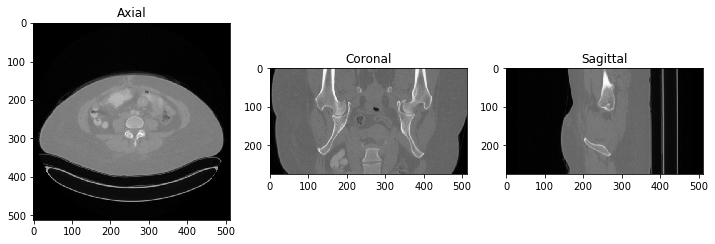

In [4]:
ut.plot_3d_img_slices(pelvic_img)

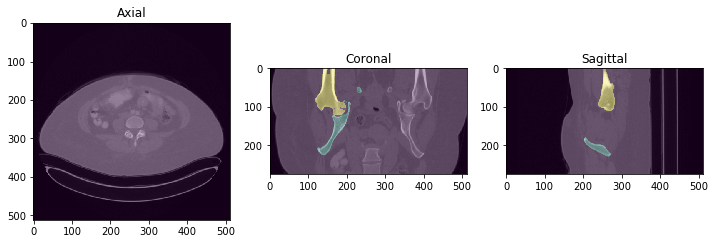

In [5]:
ut.plot_3d_img_masked(pelvic_img, pelvic_mask)

### Select only mask of interest (1 Right femur and 3 Right hip bone)

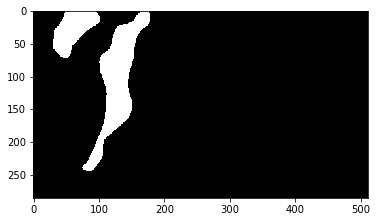

In [8]:
importlib.reload(reg)
mask_of_interest = reg.Transform.create_mask_of_interest(maskname, labels=[1,3], verbose=True)

## 1.2 Explore a Fixed and Moving Image

In [36]:
fixed_image = ut.read_image(COMMON_PATH + '40_image.nii.gz')
moving_image = ut.read_image(GROUP_PATH + '59_image.nii.gz')

In [25]:
importlib.reload(ut)
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=142, description='fixed_image_z', max=285), IntSlider(value=137, descrip…

In [39]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ut.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=142, description='image_z', max=285), FloatSlider(value=0.5, description…

<function utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

# 3. Registration
## Linear Trasform: Affine Transformation 12DOF

In [28]:
im_ref_filename = COMMON_PATH + '40_image.nii.gz'
im_mov_filename = GROUP_PATH + '59_image.nii.gz'

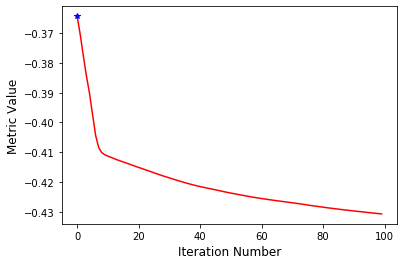

itk::simple::Transform
 AffineTransform (0000021CBA204730)
   RTTI typeinfo:   class itk::AffineTransform<double,3>
   Reference Count: 3
   Modified Time: 9104637
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.996294 -0.00512581 -0.00297742 
     -0.0200044 1.03616 -0.000356303 
     0.000230659 0.0105053 0.991705 
   Offset: [7.19741, -17.2379, -171.411]
   Center: [1, -129, 842.698]
   Translation: [5.34587, -22.223, -179.756]
   Inverse: 
     1.00382 0.00493524 0.00301556 
     0.0193798 0.965192 0.000404962 
     -0.000438771 -0.0102256 1.00836 
   Singular: 0

--------
Final metric value: -0.4306958726761932
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.
--------
Wall time: 1min 12s


In [48]:
%%time
importlib.reload(reg)
lin_trf = reg.LinearTransform(im_ref_filename=im_ref_filename,im_mov_filename=im_mov_filename)
lin_xfm = lin_trf.est_transf(metric="MI")

In [45]:
moving_image = lin_trf.apply_transf(lin_xfm)
fixed_image = lin_trf.im_mov
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=137, description='fixed_image_z', max=275), IntSlider(value=142, descrip…

In [46]:
fixed_image = lin_trf.im_ref
moving_image = lin_trf.apply_transf(lin_xfm)
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=142, description='fixed_image_z', max=285), IntSlider(value=142, descrip…

In [47]:
fixed_image = ut.read_image(COMMON_PATH + '40_image.nii.gz')
moving_image = ut.read_image(GROUP_PATH + '59_image.nii.gz')

moving_resampled = sitk.Resample(moving_image, fixed_image, lin_xfm, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ut.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=142, description='image_z', max=285), FloatSlider(value=0.5, description…

<function utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

## Non Linear Transformation  FFD 

In [49]:
%%time
importlib.reload(reg)
non_lin_trf = reg.NonLinearTransform(im_ref_filename=im_ref_filename, im_mov_filename=im_mov_filename)
non_lin_trf.im_mov = moving_resampled
non_lin_xfm = non_lin_trf.est_transf(metric="SSD")

itk::simple::Transform
 BSplineTransform (0000021CB8073460)
   RTTI typeinfo:   class itk::BSplineTransform<double,3,3>
   Reference Count: 3
   Modified Time: 11243649
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0000021CB7E1B730, 0000021CB7E1C540, 0000021CB75AABC0 ]
   TransformDomainOrigin: [-169.083, -299.083, 728.2]
   TransformDomainPhysicalDimensions: [340.166, 340.166, 228.997]
   TransformDomainDirection: 1 0 0
0 1 0
0 0 1

   TransformDomainMeshSize: [11, 11, 8]
   GridSize: [14, 14, 11]
   GridOrigin: [-200.007, -330.007, 699.575]
   GridSpacing: [30.9242, 30.9242, 28.6246]
   GridDirection: 1 0 0
0 1 0
0 0 1


--------
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 74.
Number of iterations: 74
--------
Wall time: 39min 39s


In [50]:
fixed_image = ut.read_image(COMMON_PATH + '40_image.nii.gz')
moving_image = ut.read_image(GROUP_PATH + '59_image.nii.gz')

moving_resampled = sitk.Resample(moving_image, fixed_image, non_lin_xfm, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ut.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=142, description='image_z', max=285), FloatSlider(value=0.5, description…

<function utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

# 3 Atlas Based Segmentation

In [60]:
importlib.reload(seg)
atlas_seg = seg.AtlasSegmentation()

In [61]:
atlas_seg.cmn_mask

{40: <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000021C9578BE70> >,
 41: <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000021C968AFF00> >,
 42: <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000021C97B1A480> >}